In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import mdtraj as md
from sklearn.pipeline import Pipeline
from msmbuilder.io import load_trajs, load_meta, preload_tops, load_generic
from msmbuilder.feature_extraction import DihedralFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
import numpy as np

## Load data

In [3]:
def get_timings(meta):
    frames_tot = meta['nframes'].sum()
    n_frames = meta['nframes'].unique()
    assert (len(n_frames) == 1, 'Different trajectory lengths')
    n_frames = n_frames[0]
    dt = meta['step_ps'][0]
    to_ns = dt/1000
    t_max = n_frames*to_ns
    return to_ns, t_max, frames_tot


def traj_load(irow):
    i, row = irow
    traj = md.load(row['traj_fn'], top=tops[row['top_fn']])
    return i, traj


<ipython-input-3-b7f0c528c48c>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(n_frames) == 1, 'Different trajectory lengths')


In [15]:
meta = load_meta('meta.pandas.pickl')
tops = preload_tops(meta)
trajs = [md.load(row['traj_fn'], top=tops[row['top_fn']], stride=1) 
         for i, row in meta.iterrows()]

## Get internal coordinates

In [16]:
bonds = load_generic('proc_traj/2agy_as-1_bonds.pickl')
angles = load_generic('proc_traj/2agy_as-1_angles.pickl')
dihedrals = load_generic('proc_traj/2agy_as-1_dihedrals.pickl')

## Set up the estimators for the pipeline



In [17]:
def compute_dihedrals(traj, indices):
    dihedrals = md.compute_dihedrals(traj, indices=indices)
    dihedrals = np.concatenate((np.cos(dihedrals), np.sin(dihedrals)), axis=1)
    return dihedrals

def compute_angles(traj, indices):
    angles = md.compute_angles(traj, angle_indices=indices)
    angles = np.concatenate((np.cos(angles), np.sin(angles)), axis=1)
    return angles



In [18]:
to_ns, t_max, frames_tot = get_timings(meta)


In [35]:
from msmbuilder.feature_extraction import FunctionFeaturizer, AtomPairsFeaturizer
from msmbuilder.feature_selection import FeatureSelector
from msmbuilder.cluster import LandmarkAgglomerative, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel

dihedrals_feat = FunctionFeaturizer(compute_dihedrals, func_args={'indices': dihedrals})
angles_feat = FunctionFeaturizer(compute_angles, func_args={'indices': angles})
bonds_feat = AtomPairsFeaturizer(pair_indices=bonds, periodic=True)

features = FeatureSelector([('bonds', bonds_feat), ('angles', angles_feat), ('dihedrals', dihedrals_feat)], 
                         which_feat=['bonds', 'angles', 'dihedrals'])

n_clusters = int(np.sqrt(frames_tot))
clusterer = LandmarkAgglomerative(n_clusters=n_clusters,
                                  n_landmarks=n_clusters//10,
                                  linkage='ward', metric='euclidean',
                                  landmark_strategy='stride',
                                  random_state=None, max_landmarks=None,
                                  ward_predictor='ward')
clusterer = MiniBatchKMeans(n_clusters = n_clusters)

In [36]:

estimators = [('features', features), ('variance', VarianceThreshold()),
              ('scaling', RobustScaler()), ('tICA', tICA(lag_time=int(30/to_ns), n_components=3)), 
             ('cluster',  clusterer)]
pipe = Pipeline(estimators)

In [37]:
ctraj = pipe.fit_transform(trajs)

## Run MSM for different lags

In [38]:
from sklearn.model_selection import train_test_split

# train, test = train_test_split(ftrajs, test_size=0.4, random_state=42)
to_ns, t_max, frames_tot = get_timings(meta)

start_lag = int(1/to_ns)
stop_lag = int(81/to_ns)
n_lags = 71
lags = np.linspace(start_lag, stop_lag, n_lags, dtype=int)
print(lags)

msm_timescales = 10
eigenvalues = np.zeros((lags.shape[0], msm_timescales))
# Run loop
for idx, lag in enumerate(lags): 
    msm = MarkovStateModel(lag_time=lag, n_timescales=msm_timescales)
    print('{}, '.format(lag), end='')
    msm.fit(ctraj)
    eigenvalues[idx] = msm.eigenvalues_[1:]

[ 100  214  328  442  557  671  785  900 1014 1128 1242 1357 1471 1585 1700
 1814 1928 2042 2157 2271 2385 2500 2614 2728 2842 2957 3071 3185 3300 3414
 3528 3642 3757 3871 3985 4100 4214 4328 4442 4557 4671 4785 4900 5014 5128
 5242 5357 5471 5585 5700 5814 5928 6042 6157 6271 6385 6500 6614 6728 6842
 6957 7071 7185 7300 7414 7528 7642 7757 7871 7985 8100]
100, MSM contains 2 strongly connected components above weight=0.01. Component 1 selected, with population 51.070176%
214, MSM contains 2 strongly connected components above weight=0.00. Component 1 selected, with population 51.073703%
328, MSM contains 2 strongly connected components above weight=0.00. Component 1 selected, with population 51.077313%
442, MSM contains 2 strongly connected components above weight=0.00. Component 1 selected, with population 51.081010%
557, MSM contains 2 strongly connected components above weight=0.00. Component 1 selected, with population 51.084831%
671, MSM contains 2 strongly connected components

## Plot eigenvalues


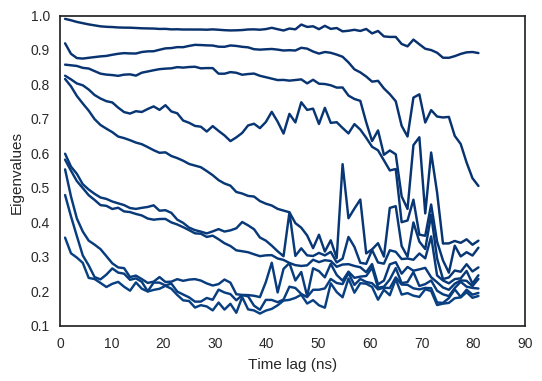

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_palette('Blues_r', 168)
sns.set_style('white')
for idx in range(msm_timescales):
    plt.plot(lags*to_ns, eigenvalues.T[idx])
plt.xlabel('Time lag (ns)')
plt.ylabel('Eigenvalues')


## Plot timescales


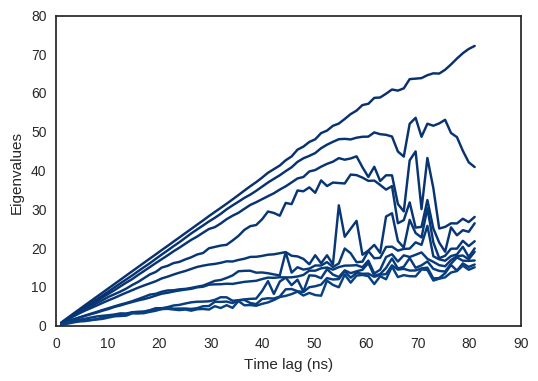

In [40]:
timescales = eigenvalues*lags[:, np.newaxis]*to_ns

sns.set_palette('Blues_r', 168)
sns.set_style('white')
for idx in range(msm_timescales):
    plt.plot(lags*to_ns, timescales.T[idx])
plt.xlabel('Time lag (ns)')
plt.ylabel('Eigenvalues')
